In [1]:
# This file generates the data for Figure #4 from the paper https://arxiv.org/pdf/1806.06975.pdf

import os 
import pickle
import argparse
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from torch.autograd import Variable

from models.model_wrapper import WrappedModel
from data import datasets
from data.graph_wrapper import GeneInteractionGraph

/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Set the sample path depending on the location of your code and dataset.
# If it is unset, the TCGA dataset will be downloaded from Academic Torrents.
reload(datasets)

#dataset = datasets.GeneDataset(file_path="/data/lisa/data/genomics/TCGA/TCGA_tissue_ppi.hdf5")
dataset = datasets.GeneDataset(at_hash="4070a45bc7dd69584f33e86ce193a2c903f0776d")

dataset.df = dataset.df - dataset.df.mean() # Make sure the dataset is normalized


Converting one-hot labels to integers


In [3]:
# On which graphs will we run this experiment? Parameterize this. 
# you will need to add your graph to AcademicTorrents and put the hash into the get_at_hash function in data/graph.py
# or simply pass the path directly into graph.load_graph() below.
graph_paths = {"regnet": "/data/lisa/data/genomics/graph/kegg.hdf5", "genemania": "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"}
graphs = {}

for graph_name in graph_paths.keys():
    graph_path = GeneInteractionGraph.get_at_hash(graph_name) # otherwise use Academic Torrents to get the file
    #graph_path = graph_paths[graph_name] # When on Mila Network
    
    gene_graph = GeneInteractionGraph(graph_path)
    mapping = dict(zip(range(0, len(dataset.df.columns)), dataset.df.columns))
    gene_graph.nx_graph = nx.relabel_nodes(gene_graph.nx_graph, mapping)
    graphs[graph_name] = gene_graph


In [4]:
# Setup the results dictionary
results_file_name = "experiments/results/fig-4.pkl"
try:
    results = pickle.load(open(results_file_name, "r"))
    print "Loaded Checkpointed Results"
    print ("Only " + str(dataset.df.shape[1] - len(results['df']['gene'].unique())) + " more genes to do...")
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'graph', 'is_first_degree', 'seed', 'train_size'])
    print "Created a New Results Dictionary"


Created a New Results Dictionary


In [5]:
# Setup Helper functions

def check_if_done(results, gene, model, graph_name, seed, train_size, is_first_degree):
    already_done = results[(results.gene == gene) &
                                 (results.model == model.name) &
                                 (results.graph == graph_name) &
                                 (results.is_first_degree == is_first_degree) &
                                 (results.seed == seed) &
                                 (results.train_size == train_size)].shape[0] > 0
    return already_done


def record_result(results, gene, model, graph_name, seed, train_size, auc, results_file_name, is_first_degree=None):
    experiment = {
        "gene": gene,
        "model": model.name,
        "graph": graph_name,
        "is_first_degree": is_first_degree,
        "seed": seed,
        "train_size": train_size,
        "auc": auc
    }

    results = results.append(experiment, ignore_index=True)
    results_dir = "/".join(results_file_name.split('/')[0:-1])

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    pickle.dump(results, open(results_file_name, "wb"))
    return results
    
def fit_and_predict(model, X_train, X_test, y_train, y_test):
    x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
    model.fit(X_train, y_train)
    y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
    auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
    model.best_model = None # cleanup
    return auc
    

In [6]:
train_size = 50
test_size = 1000
trials = 3
cuda = False
models = [WrappedModel(name="MLP", column_names=dataset.df.columns, dropout=False, cuda=cuda)]


In [13]:
# Create the set of all experiment ids and see which are left to do
model_names = [model.name for model in models]
columns = ["gene", "graph", "model", "seed", "is_first_degree", "train_size"]
all_exp_ids = [x for x in itertools.product(dataset.df.columns, graphs.keys(), model_names, range(trials), [True, False], [train_size])]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["_".join(map(str, tup[1:-1])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["_".join(map(str, tup[1:-1])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids)
print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 195303
done: 1188


In [14]:
for exp_id in todo.index:
    if len(results) % 10 == 0:
        print(len(results))
    gene, graph, model_name, seed, is_first_degree = exp_id.split("_")
    is_first_degree = bool(is_first_degree)
    seed = int(seed)
    model = [x for x in models if x.name == model_name][0]

    gene_expression_mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > gene_expression_mean else 0 for x in dataset.df[gene]]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size)

    # record the failure to the results file and continue.
    if len(set(y_train)) <= 1 or len(set(y_test)) <= 1:
        results = record_result(results, gene, model, graph_name, int(seed), train_size, 0.5, results_file_name, is_first_degree)
        continue

    if is_first_degree:
        gene_graph = graphs[graph_name]
        neighbors = list(gene_graph.first_degree(gene)[0])
        X_train = X_train[neighbors].copy()
        X_test = X_test[neighbors].copy()
    else:
        X_train = X_train.copy()
        X_test = X_test.copy()
    X_train[gene] = 1
    X_test[gene] = 1


    auc = fit_and_predict(model, X_train, X_test, y_train, y_test)
    results = record_result(results, gene, model, graph_name, seed, train_size, auc, results_file_name, is_first_degree)


1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670


KeyboardInterrupt: 

In [15]:
results

,auc,gene,model,graph,is_first_degree,seed,train_size
0,0.538755,UBE2Q1,MLP,genemania,True,0,50
1,0.463307,UBE2Q1,MLP,genemania,True,0,50
2,0.589229,UBE2Q1,MLP,genemania,True,1,50
3,0.631110,UBE2Q1,MLP,genemania,True,1,50
4,0.542314,UBE2Q1,MLP,genemania,True,2,50
5,0.480776,UBE2Q1,MLP,genemania,True,2,50
6,0.574874,UBE2Q1,MLP,genemania,True,0,50
7,0.610184,UBE2Q1,MLP,genemania,True,0,50
8,0.557692,UBE2Q1,MLP,genemania,True,1,50
9,0.579039,UBE2Q1,MLP,genemania,True,1,50


In [16]:
# Compare the performance of each graph at predicting their neighbors
df = results

first_degree = df[df['is_first_degree'] == True][df['graph'] == 'genemania'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][df['graph'] == 'genemania'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
genemania_df = first_degree.sub(full).sort_values('mean', ascending=False)

first_degree = df[df['is_first_degree'] == True][df['graph'] == 'regnet'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][df['graph'] == 'regnet'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
regnet_df = first_degree.sub(full).sort_values('mean', ascending=False)


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


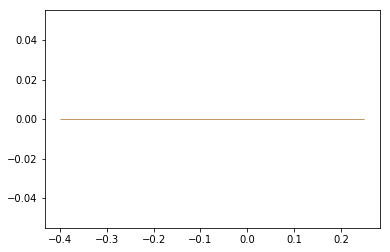

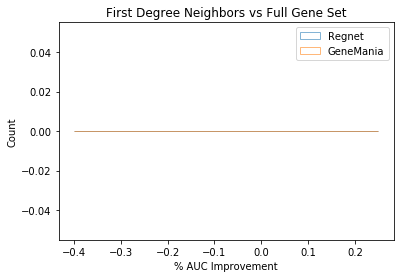

In [18]:

l1 = genemania_df['mean']
l2 = regnet_df['mean']

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", density=0, alpha=0.55, histtype='step')


fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", density=0, alpha=0.55, histtype='step')

plt.title("First Degree Neighbors vs Full Gene Set")
plt.ylabel("Count")
plt.xlabel("% AUC Improvement")

plt.legend()
plt.show()

,auc,gene_name,model,graph,is_first_degree,seed,train_size
